In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ctgan import CTGAN
from ctgan import load_demo
import data_describe as dd
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data = pd.read_csv('../data/S&P 500 Health Care 100-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data

,date,S&P 500,S&P 500 Health Care (Sector),S&P 500 Performance (%),S&P 500 Health Care (Sector) Performance (%),S&P 500 Health Care (Sector) Outperform/Underperform,overall,medical Care,medical care commodities,medical care services,personal Care
1411,1998-12-02,1171.25,362.970001,-13.299184,0.033070,OUTPERFORM,164.700,246.500,226.200,251.200,159.000
1412,1998-12-03,1150.14,352.160004,-14.349545,-1.612044,OUTPERFORM,164.700,246.500,226.200,251.200,159.000
1413,1998-12-04,1176.74,360.369995,-11.866565,1.724718,OUTPERFORM,164.700,246.500,226.200,251.200,159.000
1414,1998-12-07,1187.70,360.679993,-12.322922,0.264082,OUTPERFORM,164.700,246.500,226.200,251.200,159.000
1415,1998-12-08,1181.38,361.799988,-11.307808,1.378610,OUTPERFORM,164.700,246.500,226.200,251.200,159.000
...,...,...,...,...,...,...,...,...,...,...,...
7194,2021-11-24,4701.46,1541.250000,5.426902,-5.690106,UNDERPERFORM,280.126,531.268,379.611,580.198,247.561
7195,2021-11-26,4594.62,1534.349976,4.573863,-5.062002,UNDERPERFORM,280.126,531.268,379.611,580.198,247.561
7196,2021-11-29,4655.27,1540.150024,8.977288,-1.113328,UNDERPERFORM,280.126,531.268,379.611,580.198,247.561
7197,2021-11-30,4567.00,1510.449951,6.305224,-3.660451,UNDERPERFORM,280.126,531.268,379.611,580.198,247.561


## Using data after 2010 (Best Model)

In [3]:
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2010]
data

,year,month,date,S&P 500,S&P 500 Health Care (Sector),S&P 500 Performance (%),S&P 500 Health Care (Sector) Performance (%),S&P 500 Health Care (Sector) Outperform/Underperform,overall,medical Care,medical care commodities,medical care services,personal Care,dow
133,2010,1,2010-01-14,1148.46,376.410004,8.787618,14.987016,OUTPERFORM,217.281,384.308,311.761,406.672,206.214,3
134,2010,2,2010-02-11,1078.47,358.869995,1.716544,7.739650,OUTPERFORM,217.353,385.712,312.658,408.261,206.263,3
135,2010,3,2010-03-11,1150.24,370.440002,2.657837,8.924110,OUTPERFORM,217.403,386.589,313.219,409.253,206.024,3
136,2010,4,2010-04-08,1186.44,370.679993,13.110628,13.559212,OUTPERFORM,217.290,387.094,314.192,409.547,206.180,3
137,2010,5,2010-05-13,1157.44,351.940002,-0.285160,-1.395274,UNDERPERFORM,217.199,388.188,314.995,410.740,206.407,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,2021,7,2021-07-08,4320.82,1496.079956,-7.184331,-2.861414,OUTPERFORM,273.092,524.845,375.685,572.969,244.968,3
272,2021,8,2021-08-12,4460.83,1547.819946,-6.940799,-3.581247,OUTPERFORM,274.214,525.861,376.842,573.939,244.840,3
273,2021,9,2021-09-09,4493.28,1563.829956,-1.171440,1.890781,OUTPERFORM,276.590,528.134,379.003,576.248,246.307,3
274,2021,10,2021-10-14,4438.26,1484.189941,3.749053,-1.858116,UNDERPERFORM,278.524,529.754,379.483,578.237,246.445,3


In [4]:
original = data[['S&P 500 Health Care (Sector) Outperform/Underperform','month','overall','medical Care',\
                 'medical care commodities','medical care services','personal Care']]

In [5]:
data.drop(columns=['date','S&P 500 Health Care (Sector) Outperform/Underperform','year'], inplace=True)
data.head()

,month,S&P 500,S&P 500 Health Care (Sector),S&P 500 Performance (%),S&P 500 Health Care (Sector) Performance (%),overall,medical Care,medical care commodities,medical care services,personal Care,dow
133,1,1148.46,376.410004,8.787618,14.987016,217.281,384.308,311.761,406.672,206.214,3
134,2,1078.47,358.869995,1.716544,7.739650,217.353,385.712,312.658,408.261,206.263,3
135,3,1150.24,370.440002,2.657837,8.924110,217.403,386.589,313.219,409.253,206.024,3
136,4,1186.44,370.679993,13.110628,13.559212,217.290,387.094,314.192,409.547,206.180,3
137,5,1157.44,351.940002,-0.285160,-1.395274,217.199,388.188,314.995,410.740,206.407,3


In [6]:
original['Performance'] = np.where(original['S&P 500 Health Care (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','medical Care',\
                 'medical care commodities','medical care services','personal Care']]

In [7]:
dd.data_summary(original)

,Info
Rows,143
Columns,7
Size in Memory,8.9 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,0,1,0.49,0.50,2,73
month,int64,0,0,1,6,12,6.46,3.43,12,12
overall,float64,0,0,217.20,238.033,280.13,241.91,14.66,141,2
medical Care,float64,0,0,384.31,454.19,531.27,456.94,43.33,143,1
medical care commodities,float64,0,0,311.76,357.41,387.53,356.34,23.83,143,1
medical care services,float64,0,0,406.67,485.35,580.20,489.052,50.36,143,1
personal Care,float64,0,0,206.024,222.37,247.56,223.40,11.35,142,2


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

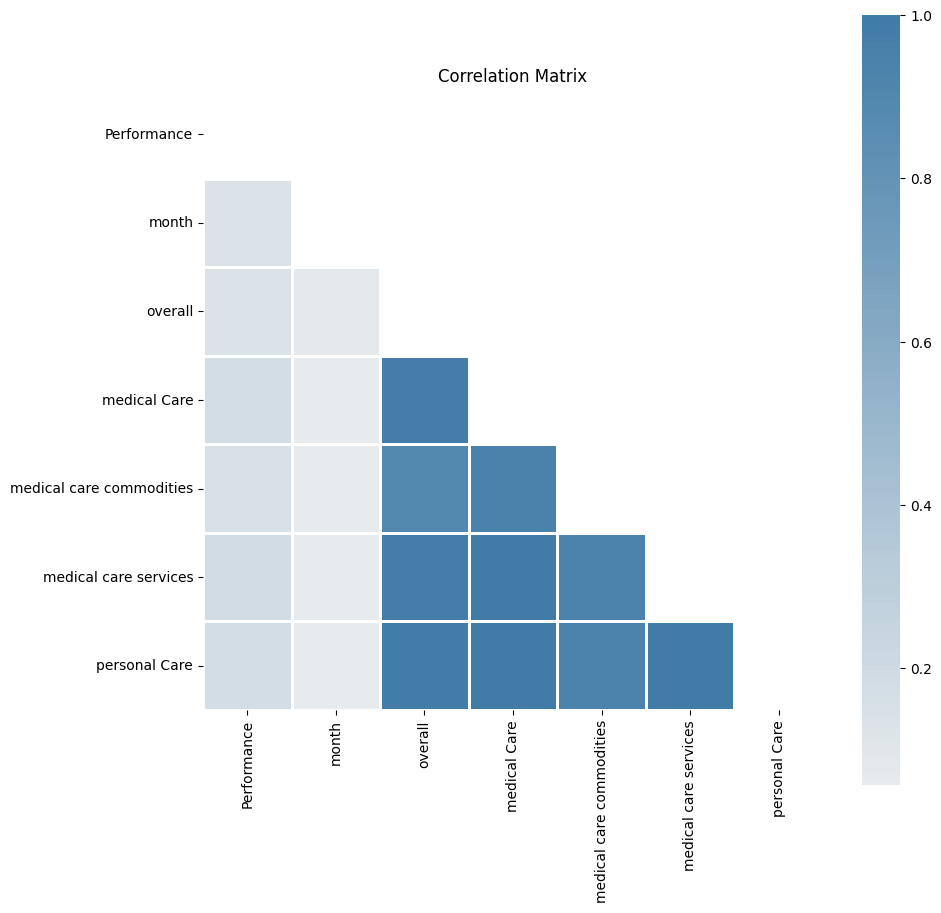

In [8]:
dd.correlation_matrix(original)

### Conditional GAN

In [9]:
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Health Care (Sector),S&P 500 Performance (%),S&P 500 Health Care (Sector) Performance (%),overall,medical Care,medical care commodities,medical care services,personal Care,dow
0,10,3033.707255,1344.305539,-9.369711,-7.960806,275.523022,552.552902,385.250212,519.511071,245.466056,3
1,8,1934.403939,631.578524,-8.666968,-1.735517,255.325248,487.082290,376.894498,489.430992,232.641987,3
2,7,4348.560584,1095.400527,-7.926466,-9.567220,240.957169,429.645326,346.450414,474.307978,219.194537,3
3,9,3846.522350,1624.295244,-11.763003,-19.291910,287.946311,564.310715,381.951739,613.354986,252.939033,3
4,8,1921.683186,614.245665,-9.473698,-7.935684,238.935772,444.534250,349.224557,518.260551,235.107556,3
...,...,...,...,...,...,...,...,...,...,...,...
9995,2,2432.736620,1076.883950,-6.205915,-1.130079,248.668771,470.002323,379.877739,543.295539,238.468096,3
9996,6,1751.365156,705.182351,-2.888752,-9.628123,238.684728,406.018393,359.753207,487.189090,211.784721,3
9997,10,2246.582184,696.320347,-7.343263,-7.922391,234.615167,452.104471,351.925587,453.462833,217.080925,3
9998,4,1856.135228,438.747612,-9.733676,-15.251108,231.085792,417.628174,354.123559,448.942664,219.472124,3


In [10]:
samples['Performance'] = np.where(samples['S&P 500 Health Care (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)

In [11]:
samples = samples[['Performance','month', 'overall','medical Care',\
                 'medical care commodities','medical care services','personal Care']]
samples.head()

,Performance,month,overall,medical Care,medical care commodities,medical care services,personal Care
0,1,10,275.523022,552.552902,385.250212,519.511071,245.466056
1,1,8,255.325248,487.082290,376.894498,489.430992,232.641987
2,0,7,240.957169,429.645326,346.450414,474.307978,219.194537
3,0,9,287.946311,564.310715,381.951739,613.354986,252.939033
4,1,8,238.935772,444.534250,349.224557,518.260551,235.107556


In [12]:
dd.data_summary(samples)

,Info
Rows,10000
Columns,7
Size in Memory,547.0 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,0,1,0.28,0.45,2,7204
month,int64,0,0,1,6,12,6.44,3.42,12,931
overall,float64,0,0,208.93,243.72,294.17,245.22,17.081,9999,2
medical Care,float64,0,0,344.20,456.79,589.33,457.86,50.11,10000,1
medical care commodities,float64,0,0,285.18,358.073,396.85,357.98,24.18,10000,1
medical care services,float64,0,0,356.50,490.46,631.50,494.98,59.0063,9999,2
personal Care,float64,0,0,193.50,222.78,260.011,224.63,13.50,10000,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

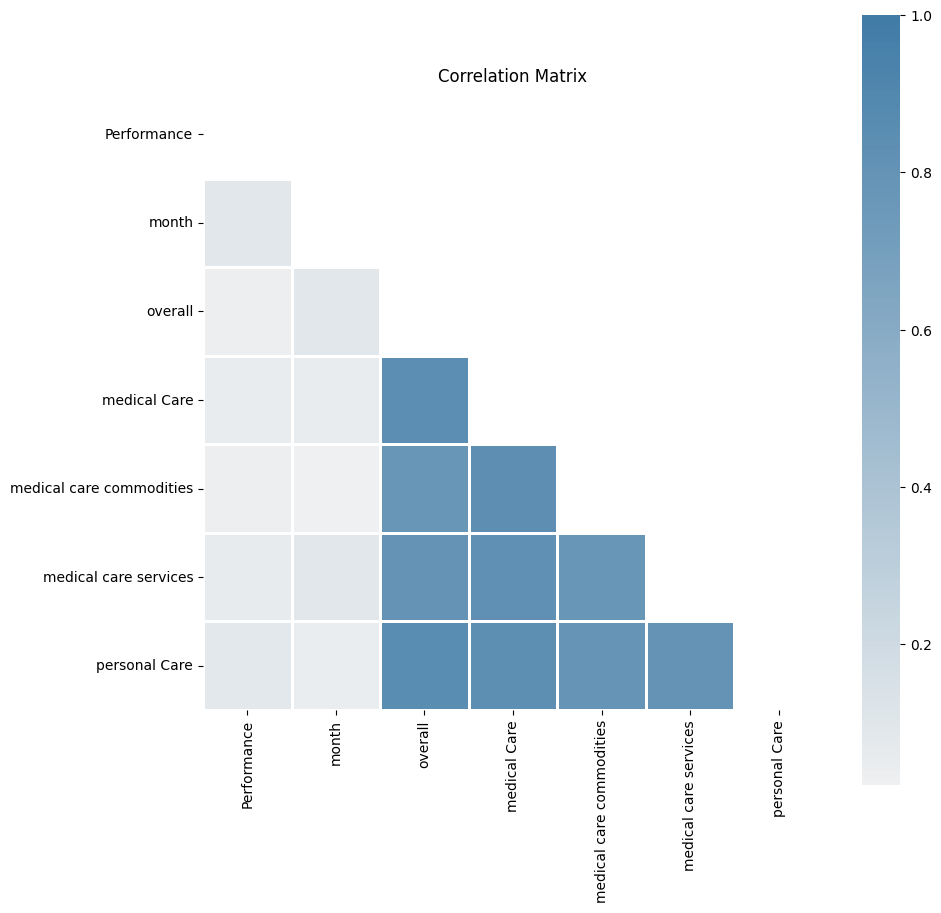

In [13]:
dd.correlation_matrix(samples)

In [14]:
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']

### SMOTE Oversampling

In [15]:
counter = Counter(y)
print(counter)
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
print(counter)

Counter({0: 7204, 1: 2796})
Counter({1: 7204, 0: 7204})


### Interaction Terms

In [16]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
X_poly

array([[   275.52302209,    552.55290233,    385.25021187, ...,
        200141.75019731,  94565.85002504, 127522.33358993],
       [   255.32524847,    487.08229042,    376.89449849, ...,
        184463.84828405,  87681.48509539, 113862.19858672],
       [   240.95716918,    429.64532589,    346.45041355, ...,
        164324.19513643,  75940.03810993, 103965.71780025],
       ...,
       [   235.53535272,    407.86641257,    341.21172412, ...,
        147028.95771778,  73621.9289625 ,  92974.142228  ],
       [   251.55169227,    485.15096243,    384.52667519, ...,
        181073.01183269,  91635.79098945, 112218.87554945],
       [   220.67207207,    400.1822561 ,    321.57537184, ...,
        133987.04441628,  64573.18129124,  83666.08151359]])

In [17]:
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X.shape

(14408, 16)

In [18]:
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
X_real.shape

(143, 16)

In [19]:
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)

### Training with CV

In [20]:
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.71433,0.678475,0.812228,0.73892,0.691838,0.656015,0.786922,0.71553,0.545455,0.537313,0.514286,0.525547
1,DecisionTreeClassifier,0.694965,0.682695,0.726572,0.703564,0.663798,0.650615,0.685457,0.667582,0.643357,0.661017,0.557143,0.604651
2,RandomForestClassifier,0.7963,0.777086,0.828071,0.800341,0.762354,0.741071,0.795378,0.767265,0.601399,0.618182,0.485714,0.544
3,AdaBoostClassifier,0.647838,0.644735,0.656197,0.649902,0.644364,0.633749,0.658399,0.645839,0.587413,0.58209,0.557143,0.569343
4,GradientBoostingClassifier,0.672894,0.661743,0.705198,0.682273,0.667129,0.651715,0.696167,0.673208,0.601399,0.594203,0.585714,0.589928
5,ExtraTreesClassifier,0.817745,0.800826,0.844169,0.820398,0.795391,0.778913,0.816234,0.797137,0.573427,0.581818,0.457143,0.512
6,BaggingClassifier,0.739246,0.742828,0.729365,0.734978,0.710161,0.714454,0.685457,0.699655,0.559441,0.563636,0.442857,0.496
7,SVC,0.638191,0.615018,0.734769,0.669113,0.637979,0.606818,0.752537,0.671867,0.545455,0.53012,0.628571,0.575163
8,GaussianNB,0.544003,0.540937,0.580098,0.559752,0.543309,0.533437,0.580045,0.555766,0.636364,0.628571,0.628571,0.628571


## Using all data 

In [21]:
data = pd.read_csv('../data/S&P 500 Health Care 100-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data

,year,month,date,S&P 500,S&P 500 Health Care (Sector),S&P 500 Performance (%),S&P 500 Health Care (Sector) Performance (%),S&P 500 Health Care (Sector) Outperform/Underperform,overall,medical Care,medical care commodities,medical care services,personal Care,dow
0,1998,12,1998-12-10,1165.02,353.089996,-12.539319,-2.253416,OUTPERFORM,164.700,246.500,226.200,251.200,159.000,3
1,1999,1,1999-01-14,1212.19,348.149994,-8.072711,0.714534,OUTPERFORM,164.700,247.300,226.900,252.000,159.400,3
2,1999,2,1999-02-11,1254.04,365.540009,-10.160045,0.841408,OUTPERFORM,164.800,247.900,227.600,252.500,159.900,3
3,1999,3,1999-03-11,1297.68,384.720001,-1.853000,13.322929,OUTPERFORM,165.900,248.700,229.000,253.100,160.000,3
4,1999,4,1999-04-08,1343.98,390.510010,1.507530,10.413373,OUTPERFORM,166.000,249.300,229.200,253.900,160.500,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,2021,7,2021-07-08,4320.82,1496.079956,-7.184331,-2.861414,OUTPERFORM,273.092,524.845,375.685,572.969,244.968,3
272,2021,8,2021-08-12,4460.83,1547.819946,-6.940799,-3.581247,OUTPERFORM,274.214,525.861,376.842,573.939,244.840,3
273,2021,9,2021-09-09,4493.28,1563.829956,-1.171440,1.890781,OUTPERFORM,276.590,528.134,379.003,576.248,246.307,3
274,2021,10,2021-10-14,4438.26,1484.189941,3.749053,-1.858116,UNDERPERFORM,278.524,529.754,379.483,578.237,246.445,3


In [22]:
original = data[['S&P 500 Health Care (Sector) Outperform/Underperform','month','overall','medical Care',\
                 'medical care commodities','medical care services','personal Care']]
data.drop(columns=['date','S&P 500 Health Care (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Health Care (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','medical Care',\
                 'medical care commodities','medical care services','personal Care']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Health Care (Sector),S&P 500 Performance (%),S&P 500 Health Care (Sector) Performance (%),overall,medical Care,medical care commodities,medical care services,personal Care,dow
0,12,1297.195145,417.764280,-12.823490,-14.817378,219.420731,390.752823,305.694547,481.496788,211.442332,3
1,2,1434.870434,390.338990,-11.512250,-12.528132,187.547354,311.305804,254.704885,302.485654,178.031725,3
2,9,2345.709113,1260.889141,-9.345160,-9.591473,252.868860,479.394794,364.921076,545.158628,230.763788,3
3,2,1224.723128,377.656140,-8.810463,-6.622816,169.884844,268.669681,240.729483,289.666415,195.536116,3
4,8,1169.865645,694.286562,-4.554632,-8.781149,247.706631,488.009247,319.186330,492.621694,222.315010,3
...,...,...,...,...,...,...,...,...,...,...,...
9995,7,1451.362590,366.897865,-2.732609,-9.529005,228.234740,450.869320,308.241361,477.557626,224.071874,3
9996,2,1343.058176,382.981120,-6.694310,-15.001295,174.137735,276.939223,230.882861,299.919883,158.438284,3
9997,12,1320.432227,355.153103,-2.370548,-6.715429,194.565124,295.207287,277.677610,324.316457,190.578062,3
9998,9,1312.942733,508.466789,-7.179704,-7.545611,264.989486,533.745978,387.630833,507.255719,240.024183,3


In [23]:
samples['Performance'] = np.where(samples['S&P 500 Health Care (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month', 'overall','medical Care',\
                 'medical care commodities','medical care services','personal Care']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.579759,0.57719,0.591992,0.584105,0.569996,0.578635,0.569343,0.573951,0.463768,0.485294,0.458333,0.471429
1,DecisionTreeClassifier,0.567038,0.56365,0.585309,0.573813,0.577052,0.582206,0.59708,0.58955,0.503623,0.535354,0.368056,0.436214
2,RandomForestClassifier,0.629991,0.638005,0.59197,0.612085,0.623097,0.6428,0.583212,0.611558,0.460145,0.474747,0.326389,0.386831
3,AdaBoostClassifier,0.612535,0.640169,0.514757,0.570107,0.603416,0.653144,0.470073,0.546689,0.525362,0.564356,0.395833,0.465306
4,GradientBoostingClassifier,0.622563,0.651293,0.528873,0.58315,0.610472,0.653295,0.49927,0.565991,0.518116,0.553398,0.395833,0.461538
5,ExtraTreesClassifier,0.635933,0.643047,0.596612,0.615842,0.624582,0.642573,0.590511,0.615443,0.518116,0.550459,0.416667,0.474308
6,BaggingClassifier,0.607242,0.623578,0.536463,0.575926,0.606387,0.63964,0.518248,0.572581,0.452899,0.46729,0.347222,0.398406
7,SVC,0.585608,0.648976,0.373078,0.473713,0.583736,0.659004,0.376642,0.479331,0.521739,0.581081,0.298611,0.394495
8,GaussianNB,0.577252,0.603761,0.449583,0.515333,0.569996,0.603718,0.450365,0.515886,0.514493,0.552083,0.368056,0.441667


### Voting Classifier

In [24]:
et_clf = ExtraTreesClassifier(random_state=random_state)
bag_clf = BaggingClassifier(random_state=random_state)
rf_clf = RandomForestClassifier(random_state=random_state)
classifiers = [('RF', rf_clf), \
               ('ET', et_clf),\
              ('Bagging', bag_clf)]

vc = VotingClassifier(estimators = classifiers, voting = 'soft')     
vc.fit(x_train, y_train)
y_pred = vc.predict(x_test)
vc_res = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F-1 Score'])
vc_res.loc[0, 'Accuracy'] = accuracy_score(y_test, y_pred)
vc_res.loc[0, 'Precision'] = precision_score(y_test, y_pred)
vc_res.loc[0, 'Recall'] = recall_score(y_test, y_pred)
vc_res.loc[0, 'F-1 Score'] = f1_score(y_test, y_pred)
vc_res

,Accuracy,Precision,Recall,F-1 Score
0,0.629781,0.649081,0.592701,0.619611
